Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

Load the Data
- These files contain 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users who joined MovieLens in 2000.

In [2]:
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
)

movielens_zipped_file = keras.utils.get_file(
    "ml-1m.zip", movielens_data_file_url, extract=False
)

keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-1m"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")
        
ratings_file = movielens_dir / "ratings.dat"
movies_file = movielens_dir / "movies.dat"

df = pd.read_csv(ratings_file, names=["userId", "movieId", "rating", "timestamp"], sep='\::', encoding='latin-1', engine='python')
movies = pd.read_csv(movies_file, names=["movieId", "title", "genres"], sep='\::', encoding='latin-1', engine='python')

In [3]:
df.sample(5)

,userId,movieId,rating,timestamp
180319,1128,1357,4,974904611
894149,5397,543,5,963524334
250241,1508,2273,2,974748504
453033,2790,3471,4,972941717
724496,4339,1049,3,965232819


In [4]:
movies.sample(5)

,movieId,title,genres
3000,3069,Effect of Gamma Rays on Man-in-the-Moon Marigo...,Drama
614,618,Two Much (1996),Comedy|Romance
3043,3112,'Night Mother (1986),Drama
3127,3196,Stalag 17 (1953),Drama|War
3151,3220,Night Tide (1961),Drama


Preparing the Data

In [5]:
# Map user ID to a "user vector" via an embedding matrix
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}

# Map movies ID to a "movies vector" via an embedding matrix
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}

df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie2movie_encoded)
df['rating'] = df['rating'].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(f"Number of users: {num_users}, Number of Movies: {num_movies}, Min Rating: {min_rating}, Max Rating: {max_rating}")

Number of users: 6040, Number of Movies: 3706, Min Rating: 1.0, Max Rating: 5.0


In [6]:
# Normalizing the targets between 0 and 1. Makes it easy to train.
df["rating"] = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating))

In [7]:
# Assuming training except for the last 5 ratings and validating the last 5 ratings
dtrain = df.sort_values(['userId','timestamp'],ascending=True).groupby('userId').apply(lambda x:x.iloc[5:]).set_index(np.arange(970009))
dtest = df.sort_values(['userId','timestamp'],ascending=True).groupby('userId').apply(lambda x:x.iloc[:5]).set_index(np.arange(30200))

In [8]:
x_train = dtrain[["user", "movie"]].values
x_val = dtest[["user", "movie"]].values
y_train = dtrain["rating"].values
y_val = dtest["rating"].values

Create the Model

- We embed both users and movies in to 100-dimentional vectors. The model computes a match score between user and movie embeddings via a dot product, and adds a per-movie and per-user bias. The match score is scalled to the[0, 1] interval via a sigmoid (since our ratings are normalized to this range).

In [9]:
EMBEDDING_SIZE = 100

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
        
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to be between 0 and 11
        return tf.nn.sigmoid(x)
    
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

Train the Model

In [10]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 64,
    epochs = 20,
    verbose = 1,
    validation_data = (x_val, y_val)
)

Epoch 1/20
15157/15157 [==============================] - 181s 12ms/step - loss: 0.6495 - accuracy: 0.2201 - recall: 0.9438 - precision: 0.9455 - val_loss: 0.6435 - val_accuracy: 0.2136 - val_recall: 0.9995 - val_precision: 0.9376
Epoch 2/20
15157/15157 [==============================] - 175s 12ms/step - loss: 0.6237 - accuracy: 0.2285 - recall: 0.9973 - precision: 0.9456 - val_loss: 0.6324 - val_accuracy: 0.2173 - val_recall: 0.9900 - val_precision: 0.9407
Epoch 3/20
15157/15157 [==============================] - 175s 12ms/step - loss: 0.6132 - accuracy: 0.2372 - recall: 0.9759 - precision: 0.9534 - val_loss: 0.6265 - val_accuracy: 0.2239 - val_recall: 0.9669 - val_precision: 0.9466
Epoch 4/20
15157/15157 [==============================] - 193s 13ms/step - loss: 0.6065 - accuracy: 0.2453 - recall: 0.9456 - precision: 0.9612 - val_loss: 0.6230 - val_accuracy: 0.2293 - val_recall: 0.9443 - val_precision: 0.9518
Epoch 5/20
15157/15157 [==============================] - 181s 12ms/step - l

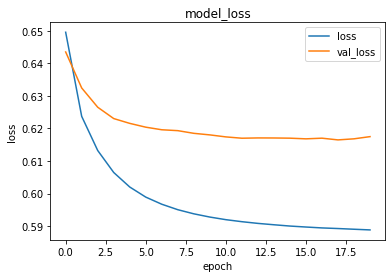

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

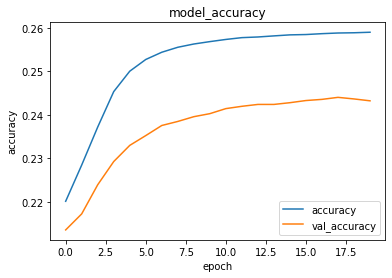

In [17]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

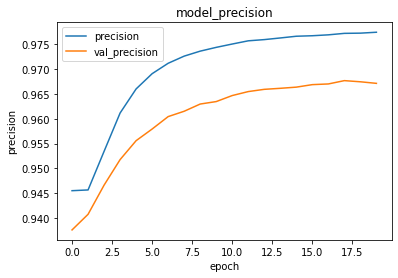

In [18]:
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.title('model_precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend()

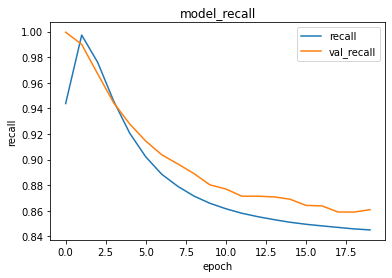

In [19]:
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.title('model_recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend()

Show top 5 movie recommendations to a sample user

In [32]:
def recommend_movie(sample_user_id):
    movies_watched_by_user = df[df.userId == sample_user_id]
    movies_not_watched = movies[~movies['movieId'].isin(movies_watched_by_user.movieId.values)]['movieId']
    movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))
    movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
    user_encoder = user2user_encoded.get(sample_user_id)
    user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched))
    ratings = model.predict(user_movie_array).flatten()
    top_ratings_indices = ratings.argsort()[-5:][::-1]
    recommended_movie_ids = [movie2movie_encoded.get(movies_not_watched[x][0]) for x in top_ratings_indices]
    return movies[movies["movieId"].isin(recommended_movie_ids)]

In [30]:
sample_user_id = df.userId.sample(1).iloc[0]
sample_user_id

3199

In [33]:
recommend_movie(sample_user_id)

,movieId,title,genres
913,925,Golden Earrings (1947),Adventure|Romance
1814,1883,Bulworth (1998),Comedy
1884,1953,"French Connection, The (1971)",Action|Crime|Drama|Thriller
2622,2691,"Legend of 1900, The (Leggenda del pianista sul...",Drama
3200,3269,Forever Young (1992),Adventure|Romance|Sci-Fi


In [34]:
print("Showing recommendations for user: {}".format(sample_user_id))
print("-------" * 5)
print("The last 5 movies rated by the user")
print("-------" * 5)
test = dtest[dtest.userId == sample_user_id].movieId.values
movies_rows = movies[movies["movieId"].isin(test)]
for row in movies_rows.itertuples():
    print(row.title, ":", row.genres)

print("-------" * 5)
print("The top 5 movies recommendations")
print("-------" * 5)
recommended_movies = recommend_movie(sample_user_id)
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 3199
-----------------------------------
The last 5 movies rated by the user
-----------------------------------
Ransom (1996) : Drama|Thriller
Back to the Future (1985) : Comedy|Sci-Fi
Beavis and Butt-head Do America (1996) : Animation|Comedy
Liar Liar (1997) : Comedy
Mad Max (1979) : Action|Sci-Fi
-----------------------------------
The top 5 movies recommendations
-----------------------------------
Golden Earrings (1947) : Adventure|Romance
Bulworth (1998) : Comedy
French Connection, The (1971) : Action|Crime|Drama|Thriller
Legend of 1900, The (Leggenda del pianista sull'oceano) (1998) : Drama
Forever Young (1992) : Adventure|Romance|Sci-Fi


In [16]:
#model.save_weights("my_model.h5")

In [26]:
#pip freeze > requirements.txt